# Shor's algorithm

## Conditions
The number to factor must not be
- a prime number (since that is what we are looking for)
- an even number (as 2 would be a factor)
- of the form n<sup>x</sup>

## Steps
1. Let *N* be the number to factor. Make sure it meets all the requirements. In this example, we factor 15 (*N* = 15)
2. Choose a random number *k* between 1 and *N* (*k* = 7)
3. Find the greatest common denominator (GCD) between *k* and *N*. The Euclid division algorithm on a classical computer can find the GCD.
    - If the GCD is not equal to 1, we have finished and found one of the factors
    - If the GCD is 1, proceed to step 4
    - GDC(15,7) = 1 (7 is coprime to 15)
4. We must find the smallest positive integer *r* such that if *f(x) = kˣ mod N*, then *f(a) = f(a+r)*. How to determine *r*?
    - 4.1 Set variable *q* = 1
    - 4.2 Calculate *(q * k) mod N*. If the remainder is 1, go to step 4.3. Otherwise, set the value of '*q*' to the value of the resulting remainder. Repeat this step until you get remainder = 1 and keep track of how many times you have performed the transformation. Don't forget to change the value of '*q*' each time.
        Example: <br>
        
        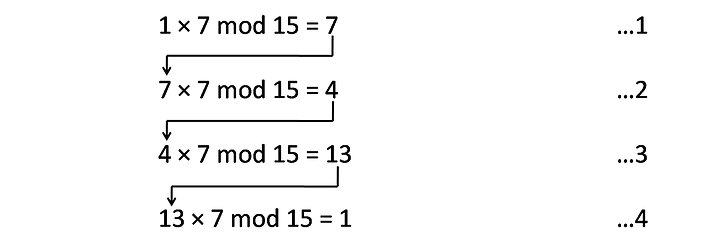
        
       </br>
    - 4.3 The number of transformations performed in step 4.2 is the value of *r* (*r* = 4)
    - *(q * k) mod N* is a periodic function. The coefficients of the qubit states fluctuate like an audio signal throughout the qubit register. The quantum Fourier transform makes it possible to determine the periodicity of the function.
    <br>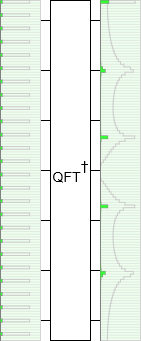!</br>
5. If *r* is odd, go back to step 2 and choose a new value for *k*. Since *r* = 4, we continue to step 6
6. Define *p = remainder* of the (*r*/2)th transformation in step 4.2.
    - If *p + 1 = N*, return to step 2 and choose a new value of *k*
    - Otherwise, proceed to step 7
    - Example: *p = 4* is the remainder of the (4/2)th, therefore the 2nd, transformation; *4 + 1 = 5* is not equal to 15, so we continue
7. Final step: The factors of *N* are *f₁ = GCD (p+1, N)* and *f₂ = GCD (p-1, N)*
    - Example: *f₁ = GCD (p+1, N)* = GDC(5,15) = 5; *f₂ = GCD (p-1, N)* = GDC(3,15) = 3. Then the factors of 15 are 3 and 5
    
## Graphical representation of the algorithm
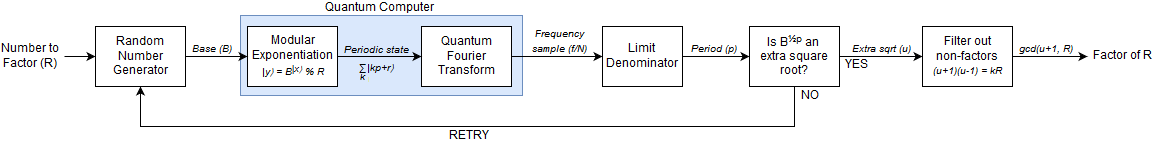
(https://algassert.com/post/1718)

In [ ]:
import cirq
import matplotlib.pyplot as plt
import numpy as np
from math import gcd
from fractions import Fraction
import pandas as pd
from numpy.random import randint
from cirq.contrib.svg import SVGCircuit # This library will be used to display quantum circuits in a more readable way.

In [ ]:
# The number of calculation qubits must be large enough to include several periods of the function f(x).
# The number of comparison qubits is of the order of magnitude of N (2^4 = 16, which includes N = 15).

compute_qubits = 8
work_qubits = 4
nb_qubits = compute_qubits+work_qubits # The number of qubits to represent the secret binary.
qubits = cirq.LineQubit.range(nb_qubits) # Creation of qubits.
k = 7 #Coprime guess

In [ ]:
# A class is a code pattern for creating objects, a gate in this case

class AMod15(cirq.Gate):
    def __init__(self,k,exponent):
        super(AMod15, self)
        self.k = k
        self.exponent = exponent

    def _num_qubits_(self):
        return 4

    def _decompose_(self, qubits):
        """gate controlled by k mod 15"""
        q0,q1,q2,q3 = qubits
        k =self.k
        power=self.exponent
        if k not in [2,4,7,8,11,13]:
            raise ValueError("'k' has to be: 2,4,7,8,11 or 13")
        for _iteration in range(power):
            if k in [2,13]:
                yield cirq.SWAP(q2,q3)
                yield cirq.SWAP(q1,q2)
                yield cirq.SWAP(q0,q1)
            if k in [7,8]:
                yield cirq.SWAP(q0,q1)
                yield cirq.SWAP(q1,q2)
                yield cirq.SWAP(q2,q3)
            if k in [4, 11]:
                yield cirq.SWAP(q1,q3)
                yield cirq.SWAP(q0,q2)
            if k in [7,11,13]:
                for q in range(4):
                    yield cirq.X(qubits[q])

    def _circuit_diagram_info_(self, args):
        return [str(self.k)+"^"+str(self.exponent)+" mod 15"] * self.num_qubits()

In [ ]:
class QFTDagger(cirq.Gate):
    def __init__(self,n):
        super(QFTDagger, self)
        self.n = n

    def _num_qubits_(self):
        return self.n

    def _decompose_(self, qubits):
        """A gate that makes the inverse of the quantum Fourier transform"""
        for qubit in range(self.n//2):
            yield cirq.SWAP(qubits[qubit], qubits[self.n-qubit-1])
        for j in range(self.n):
            for m in range(j):
                yield cirq.cphase(-np.pi/float(2**(j-m))).on(qubits[j], qubits[m])
            yield cirq.H(qubits[j])

    def _circuit_diagram_info_(self, args):
        return ["QFT†"] * self.num_qubits()

In [ ]:
"""Apply the initial state of superposition and phase for Shor's algorithm"""
def initial_gates():
    for i in range(8):
        yield cirq.H(qubits[i])
    yield cirq.X(qubits[nb_qubits-work_qubits])

In [ ]:
def apply_controlled_a_mod15():
    for q in range(nb_qubits-4):
        yield cirq.ControlledGate(sub_gate=AMod15(k=k,exponent=2**q), num_controls=1).on(qubits[q], qubits[compute_qubits], qubits[compute_qubits+1], qubits[compute_qubits+2], qubits[compute_qubits+3])

In [ ]:
circuit = cirq.Circuit(
    initial_gates(),
    apply_controlled_a_mod15(),
    QFTDagger(compute_qubits)(*qubits[0:compute_qubits]),
    cirq.measure(*qubits[0:8], key='result')
)

print("Circuit:")
SVGCircuit(circuit)

In [ ]:
# initialise the simulator.
simulator = cirq.Simulator()

print('Simulated circuit:')
results = simulator.simulate(circuit)
print(results)

# Simulate the circuit.
runs = simulator.run(circuit, repetitions=1000)

# count the results.
counts = runs.histogram(key='result')
print(counts)

# Print the results in a graph.
cirq.plot_state_histogram(counts, plt.subplot())
plt.show()

In [ ]:
# This section inverses the order of the qubits to show the binary result in the proper order
column = []
for reponse in counts.keys():
    phase = int(format(reponse, "0"+str(compute_qubits)+"b")[::-1],2)
    fraction = Fraction(phase/2**(nb_qubits-4)).limit_denominator(15)
    column.append([phase,
                f"{fraction.numerator}/{fraction.denominator}",
                fraction.denominator])
titles=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(column, columns=titles)
print(df)

In [ ]:
def a2jmodN(a, j, N):
    """gives the result of a^{2^j} (mod N) by repeated squares"""
    for _ in range(j):
        a = np.mod(k**2, N)
    return a

In [ ]:
print(a2jmodN(7, 2049, 53))

In [ ]:
N = 15
np.random.seed(1) # test with the same random numbers
k = randint(2, 15)
print(k)

In [ ]:
gcd(k, N)

In [ ]:
def qpe_amod15(a):
    """Quantum phase estimation on the k*r mod 15
    Args:
        k (int): The same 'k' from k*r mod 15
    Returns:
        float: the phase estimation
    """
    N_COUNT = 8
    qubits = cirq.LineQubit.range(N_COUNT+4)

    def algo():
        for q in range(N_COUNT):
            yield cirq.H(qubits[q])
        yield cirq.X(qubits[N_COUNT+3])
        for q in range(N_COUNT):
            yield cirq.ControlledGate(sub_gate=AMod15(k=k,exponent=2**q), num_controls=1).on(qubits[q], qubits[N_COUNT], qubits[N_COUNT+1], qubits[N_COUNT+2], qubits[N_COUNT+3])
        yield QFTDagger(N_COUNT)(*qubits[0:N_COUNT])
        yield cirq.measure(*qubits[0:N_COUNT], key='result')
    
    circuit = cirq.Circuit(algo())

    # Simulate the circuit.
    runs = simulator.run(circuit, repetitions=1000)

    # count the results.
    counts = runs.histogram(key='result')
    print(counts)

    reading = str(int(format(list(counts.keys())[0], "0"+str(compute_qubits)+"b")[::-1],2))
    print("Register Reading: " + reading)
    phase = int(reading)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [ ]:
phase = qpe_amod15(k) # Phase = s/r
Fraction(phase).limit_denominator(15)

In [ ]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

In [ ]:
guesses = [gcd(k**(r//2)-1, N), gcd(k**(r//2)+1, N)]
print(guesses)

In [ ]:
a = 7
FOUND_FACTOR = False
TRIES = 0
while not FOUND_FACTOR:
    TRIES += 1
    print(f"\nESSAIE {TRIES}:")
    phase = qpe_amod15(a) # Phase = s/r
    fraction = Fraction(phase).limit_denominator(N)
    r = fraction.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for the factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(k**(r//2)-1, N), gcd(k**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guesse in guesses:
            if guesse not in [1,N] and (N % guesse) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guesse} ***")
                FOUND_FACTOR = True